In [1]:
import numpy as np
import yaml
import cv2
import torch
import torch.nn as nn
import json
import xml
from xml.etree import ElementTree
import os
import sys
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
print("OpenCV version: ", cv2.__version__)
print("PyTorch version: ", torch.__version__)
print("NumPy version: ", np.__version__)
print("Matplotlib version: ", np.__version__)

OpenCV version:  3.4.3
PyTorch version:  1.1.0
NumPy version:  1.15.1
Matplotlib version:  1.15.1


In [8]:
config = yaml.safe_load(open("../config.yaml"))

# Show config Params
for k,v in config.items():
    print(k, "\t:\t", v)

jupyter 	:	 False
data_count 	:	 50
save_plots_loc 	:	 images/
num_anchors 	:	 2
ds_loc 	:	 ../face_detect/datasets/archive/
ds_test 	:	 True
num_classes 	:	 4
img_size 	:	 416
DEBUG_MODE 	:	 False


In [9]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def open_traffic_ds(config):
    imgs = []
    annots = []
    if(config["ds_test"]):
        # Get images
        for idx,im_file in (enumerate(sorted(os.listdir("../"+config["ds_loc"]+"images/"),key=natural_keys))):
            if(config['DEBUG_MODE'] and idx == config["data_count"]):
                break
            xml_file = im_file.split(".")[0] + ".xml"
            tree = ElementTree.parse("../"+config["ds_loc"]+"annotations/"+xml_file)
            im_data = get_xml_data(tree)
            
            img = cv2.imread("../"+config["ds_loc"]+"images/"+im_file)
            imgs.append(img)
            annots.append(im_data)
    
    return imgs,annots


def get_xml_data(tree):
    root = tree.getroot()
    bboxes = []
    file_name = ''
    w = 0
    h = 0
    x_min = 0
    x_max = 0
    y_min = 0
    y_max = 0
    im_data = {
        'filename': file_name,
        'w' : 0,
        'h' : 0,
        'bboxes': bboxes
    }
    for item in root:
        if(item.tag == 'filename'):
            im_data['filename'] = item.text
        if(item.tag == "size"):
            im_data['w'] = int(item[0].text)
            im_data['h'] = int(item[1].text)
        if(item.tag == "object"):
            for obj_items in item:
                if(obj_items.tag == "bndbox"):
                    bbox_data = {
                        'x_min' : 0,
                        'x_max' : 0,
                        'y_min' : 0,
                        'y_max' : 0,
                        'x_mid' : 0,
                        'y_mid' : 0
                    }
                    bbox_data['x_min'] = int(obj_items[0].text)
                    bbox_data['y_min'] = int(obj_items[1].text)
                    bbox_data['x_max'] = int(obj_items[2].text)
                    bbox_data['y_max'] = int(obj_items[3].text)
                    
                    # Calculating the mid-point of the bbox
                    bbox_data['x_mid'] = np.floor( 1/2 * (bbox_data['x_min'] + bbox_data['x_max']) )
                    bbox_data['y_mid'] = np.floor( 1/2 * (bbox_data['y_min'] + bbox_data['y_max']) )
                    bboxes.append(bbox_data)
    im_data['bboxes'] = bboxes
    return im_data

In [10]:
imgs, annots = open_traffic_ds(config)

In [11]:
print("Number of Images:\t", len(imgs))
print("Number of Y:\t\t", len(annots))
print(imgs[22].shape)
print(annots[22])

Number of Images:	 877
Number of Y:		 877
(400, 321, 3)
{'filename': 'road22.png', 'h': 400, 'w': 321, 'bboxes': [{'x_mid': 129.0, 'x_max': 150, 'y_max': 182, 'y_mid': 112.0, 'y_min': 43, 'x_min': 108}, {'x_mid': 79.0, 'x_max': 105, 'y_max': 149, 'y_mid': 98.0, 'y_min': 47, 'x_min': 54}, {'x_mid': 215.0, 'x_max': 284, 'y_max': 370, 'y_mid': 299.0, 'y_min': 228, 'x_min': 146}]}


In [12]:
class DataPrepper:
    
    def __init__(self, x_data=None, y_data=None):
        self.x_data = x_data
        self.y_data = y_data
        pass
    
    
    def rescale_data(self,x_data,y_data):
        """
        In order for the model to learn the locations of the objects
        we need to rescale the images and bounding boxes to the same
        height and width
        
        Due to the fact that the data is given in varying dimensions,
        we need to set it to a set size
        """
        
        for idx,img in enumerate(x_data):
            y = y_data[idx]
            
            # Resize img
            im_resized = cv2.resize(
                img,
                (config['img_size'],config['img_size'])
            )
            x_data[idx] = im_resized
            
            # Rescale y_data accordingly
            x_scaler = config['img_size'] / y['w']
            y_scaler = config['img_size'] / y['h']
            
            y['w'] = config['img_size']
            y['h'] = config['img_size']
            
            # Rescale each bbox
            for bbox in y['bboxes']:
                bbox['x_min'] = int(( bbox['x_min'] * x_scaler ))
                bbox['x_max'] = int(( bbox['x_max'] * x_scaler ))

                bbox['y_min'] = int(( bbox['y_min'] * y_scaler ))
                bbox['y_max'] = int(( bbox['y_max'] * y_scaler ))

                bbox['x_mid'] = int(( bbox['x_mid'] * x_scaler ))
                bbox['y_mid'] = int(( bbox['y_mid'] * y_scaler ))
            
            y_data[idx] = y
        return x_data, y_data
        
    
    def normalize(self,x_data,y_data):
        for idx,img in enumerate(x_data):
            y = y_data[idx]
            
            # normalize img
            img = img[:, :, ::-1].transpose(0,1,2)
            img = np.ascontiguousarray(img, dtype=np.float32)
            img /= 255.0
            
            y['w'] = config['img_size']/config['img_size']
            y['h'] = config['img_size']/config['img_size']
            
            # normalize bboxes
            for bbox in y['bboxes']:
                bbox['x_min'] /= config['img_size']
                bbox['x_max'] /= config['img_size']

                bbox['y_min'] /= config['img_size']
                bbox['y_max'] /= config['img_size']

                bbox['x_mid'] /= config['img_size']
                bbox['y_mid'] /= config['img_size']
            
            x_data[idx] = img
            y_data[idx] = y
        return x_data, y_data
    
    def draw_grid(self,img,y_data):
        # Visualize the grid cells that YOLO will be using to track an objects location
        x = np.floor(y_data['w'] / config['num_grid_cells'])
        y = np.floor(y_data['h'] / config['num_grid_cells'])

        move_x = x
        move_y = y
        plt.imshow(img)
        for i in range(config['num_grid_cells']):
            plt.plot([move_x,move_x],[0,y_data['h']],color='r',marker='.')
            plt.plot([0,y_data['w']],[move_y,move_y],color='r',marker='.')
            move_x += x
            move_y += y
        plt.show()
        
    def visualize_data(self,img,data):
        print(data['h'])
        print(data['w'])
        fig,ax = plt.subplots(1)
        plt.imshow(img)
        
        for bbox in data['bboxes']:
            rect = patches.Rectangle(
                (bbox['x_min'],bbox['y_min']),
                bbox['x_max']-bbox['x_min'],
                bbox['y_max']-bbox['y_min'],
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            pt = plt.plot(bbox['x_mid'],bbox['y_mid'],color='r',marker='.')
            ax.add_patch(rect)
        plt.show()
        plt.cla()
        plt.clf()
        plt.close()

In [13]:
# Visualizing the grid that YOLO will be using to looking for objects and their location
dp = DataPrepper(x_data=imgs,y_data=annots)

In [14]:
dp.x_data_scaled,dp.y_data_scaled = dp.rescale_data(dp.x_data,dp.y_data)

In [15]:
print("Number of examples = ",len(dp.x_data_scaled))
print("Shape of each example = ", dp.x_data_scaled[0].shape)
print("Number of y examples = ", len(dp.y_data_scaled))
print(dp.y_data_scaled[0])

Number of examples =  877
Shape of each example =  (416, 416, 3)
Number of y examples =  877
{'filename': 'road0.png', 'h': 416, 'w': 416, 'bboxes': [{'x_mid': 238, 'x_max': 324, 'y_max': 241, 'y_mid': 152, 'y_min': 64, 'x_min': 152}]}


## Analysis of Boxes

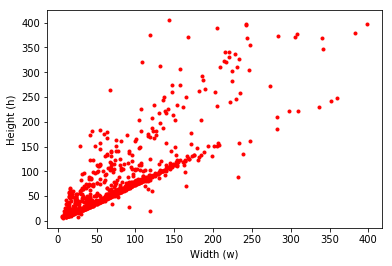

In [16]:
def h_vs_w(y_data):
    
    h = []
    w = []
    for idx,y in enumerate(y_data):
        for box in y['bboxes']:
            h.append(box['y_max'] - box['y_min'])
            w.append(box['x_max'] - box['x_min'])
    
    plt.xlabel("Width (w)")
    plt.ylabel("Height (h)")
    plt.scatter(w,h,color='r',marker='.')

h_vs_w(dp.y_data_scaled)

In [34]:
import random
import numpy as np
import yaml
import cv2
import json
import xml
from xml.etree import ElementTree
import os
import sys
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

config = yaml.safe_load(open("../config.yaml"))

class KMeans:
    def __init__(self,k,dataset):
        self.num_clusters = k
        self.bboxes = []
        for example in dataset:
            for bbox in example['bboxes']:
                # Placing boxes at the origin
                self.bboxes.append({
                    'x_min' : 0,
                    'y_min' : 0,
                    'x_max' : bbox['x_max'] - bbox['x_min'],
                    'y_max' : bbox['y_max'] - bbox['y_min'],
                    'x_mid' : 1/2 * (bbox['x_max'] - bbox['x_min']),
                    'y_mid' : 1/2 * (bbox['y_max'] - bbox['y_min'])
                })
        pass
    
    def gen_random_centroids(self):
        # First generate the random indicies
        #print(len(self.bboxes))
        rand_idx = []
        rand_idx = [ random.randrange(len(self.bboxes)) for i in range(self.num_clusters) ]
        centroids = [ self.bboxes[i] for i in rand_idx ]
        return centroids
    
    def create_clusters(self):
        # Create lists for the number of clusters
        # each list represents a cluster
        clusters = []
        for i in range(self.num_clusters):
            clusters.append([])        
        return clusters
    
    def visualize_data(self,bboxes,xlim_l=-1,xlim_r=300,ylim_l=-1,ylim_r=300):
        fig,ax = plt.subplots()
        
        for bbox in bboxes:
            rect = patches.Rectangle(
                (bbox['x_min'],bbox['y_min']),
                bbox['x_max']-bbox['x_min'],
                bbox['y_max']-bbox['y_min'],
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
        
        plt.xlim(xlim_l,xlim_r)
        plt.ylim(ylim_l,ylim_r)
        
        plt.show()
    
    def iou(self,bbox1,bbox2,visualize=False,debug=False):
        max_min_x = max(bbox1['x_min'],bbox2['x_min'])
        min_max_x = min(bbox1['x_max'],bbox2['x_max'])
        intersection_x = min_max_x - max_min_x
        
        max_min_y = max(bbox1['y_min'],bbox2['y_min'])
        min_max_y = min(bbox1['y_max'],bbox2['y_max'])
        intersection_y = min_max_y - max_min_y
        
        intersection_area = intersection_x * intersection_y
        if(intersection_x <= 0 or intersection_y <= 0 or intersection_area <= 0):
            iou = 0
        else:
            # Calculate Area of each box
            bbox1_area = (bbox1['x_max'] - bbox1['x_min']) * (bbox1['y_max'] - bbox1['y_min'])
            bbox2_area = (bbox2['x_max'] - bbox2['x_min']) * (bbox2['y_max'] - bbox2['y_min'])

            iou = (intersection_area)/(bbox1_area + bbox2_area - intersection_area)
        return iou
        
    def iou_2(self,centroids,bbox,visualize=False,debug=False):
        """
        iou_2 is very similar to iou, the difference is that
        centroids in this case is an array of bboxes which is
        of size (k)
        """
        cluster_iou = []
        for c_box in centroids:
                       
            max_min_x = max(c_box['x_min'],bbox['x_min'])
            min_max_x = min(c_box['x_max'],bbox['x_max'])
            intersection_x = min_max_x - max_min_x 
            
            max_min_y = max(c_box['y_min'],bbox['y_min'])
            min_max_y = min(c_box['y_max'],bbox['y_max'])
            intersection_y = min_max_y - max_min_y
            
            intersection_area = intersection_x * intersection_y
            
            if(debug):
                print('i_x = ', intersection_x)
                print('i_y = ', intersection_y)
                print("I_A = ", intersection_area)
            
            if(intersection_x <= 0 or intersection_y <= 0 or intersection_area <= 0):
                # If boxes are not intersected
                iou = 0
                if(visualize):
                    self.visualize_data(bbox,c_box)
            else:
                # Calculate Area of each box
                bbox_area = (bbox['x_max'] - bbox['x_min']) * (bbox['y_max'] - bbox['y_min'])
                c_box_area = (c_box['x_max'] - c_box['x_min']) * (c_box['y_max'] - c_box['y_min'])
                iou = (intersection_area)/(bbox_area + c_box_area - intersection_area)
            if(debug):
                print("iou = ", iou)
            cluster_iou.append(iou)
        if(debug):
            print(cluster_iou)
        return np.array(cluster_iou)
    
    def avg_iou(self,dataset,centroids): 
        sum = 0
        for bbox in self.bboxes:
            sum += max(self.iou_2(centroids,bbox))
        return sum/len(self.bboxes)
    
    def recalculate_centroids(self,centroids,clusters,debug=False):
        cluster_sums = []
        for cluster in clusters:
            cluster_sum = {
                        'x_min' : 0,
                        'x_max' : 0,
                        'y_min' : 0,
                        'y_max' : 0,
                        'x_mid' : 0,
                        'y_mid' : 0
                    }
            for bbox in cluster:
                cluster_sum['x_min'] += bbox['x_min']
                cluster_sum['y_min'] += bbox['y_min']
                cluster_sum['x_max'] += bbox['x_max']
                cluster_sum['y_max'] += bbox['y_max']
                cluster_sum['x_mid'] += bbox['x_mid']
                cluster_sum['y_mid'] += bbox['y_mid']
            cluster_sums.append(cluster_sum)
        
        # Calculate the mean for each sum
        for i in range(self.num_clusters):
            if(len(clusters[i]) > 0):
                centroids[i]['x_min'] = cluster_sums[i]['x_min']/len(clusters[i])
                centroids[i]['y_min'] = cluster_sums[i]['y_min']/len(clusters[i])
                centroids[i]['x_max'] = cluster_sums[i]['x_max']/len(clusters[i])
                centroids[i]['y_max'] = cluster_sums[i]['y_max']/len(clusters[i])
                centroids[i]['x_mid'] = cluster_sums[i]['x_mid']/len(clusters[i])
                centroids[i]['y_mid'] = cluster_sums[i]['y_mid']/len(clusters[i])
                
        if(debug):
            self.visualize_data(centroids[0],centroids[1])
        return centroids
    
    def write_anchors(self,centroids):
        anchors = {}
        for idx,anchor in enumerate(centroids):
            anchors["anchor"+str(idx+1)] = anchor
        json_anchors = json.dumps(anchors,sort_keys=False, indent=4)
        anchor_file = open("anchors.json","w+")
        
        sys.stdout = anchor_file
        print(json_anchors)
        sys.stdout = sys.__stdout__
        anchor_file.close()
        print("[SUCCESS]: Anchor boxes written to file.")
        
    def fit(self,max_iterations=1,debug=False):
        # generate the init random centroids
        self.centroids = self.gen_random_centroids()
        
        # Create the initial clusters
        clusters = self.create_clusters()

        old_centroids = None
        old_min_clusters = np.ones(len(self.bboxes))*(-1)
        
        iteration = 0
        while True:
            distances = []
            # Compare boxes to centroids
            for bbox in self.bboxes:
                cluster_iou = []
                for centroid in self.centroids:
                    iou = self.iou(centroid,bbox)
                    cluster_iou.append(iou)
                cluster_iou = np.array(cluster_iou)
                iou_distance = 1 - cluster_iou
                distances.append(iou_distance)
            distances = np.array(distances)
            
            min_clusters = np.argmin(distances,axis=1)
            
            if(min_clusters == old_min_clusters).all():
                print("DONE! Iteration = {} ".format(iteration))
                avg_iou = self.avg_iou(self.bboxes,self.centroids)
                print("Accuracy = ", avg_iou)
                if(debug):
                    print("Anchors: ", self.centroids)
                return self.centroids, avg_iou
            
            #print(len(min_clusters))
            #print(len(self.bboxes))
            
            # Assigning bboxes to their respective nearest clusters
            for idx,bbox in enumerate(self.bboxes):
                cluster_idx = min_clusters[idx]
                clusters[cluster_idx].append(bbox)
            
            # Recalculate the centroids for each cluster
            self.centroids = self.recalculate_centroids(self.centroids,clusters)
            
            # Save the previous min_clusters to check if the clusters change in the next iteration
            old_min_clusters = min_clusters.copy()
            iteration += 1
            
    def fit_average(self,max_iterations=1):
        centroids = self.gen_random_centroids()
        all_anchors = []
        all_avg_ious = []
        for kmeans_iteration in range(max_iterations):
            self.centroids, avg_iou = self.fit()
            all_anchors.append(self.centroids)
            all_avg_ious.append(avg_iou)
        # Average of all anchors
        self.centroids = self.recalculate_centroids(self.centroids,all_anchors)
        mean_average_iou = np.mean(all_avg_ious)
        return self.centroids, mean_average_iou

DONE! Iteration = 20 
Accuracy =  0.4901549292362059


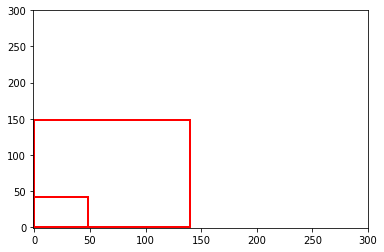

In [26]:
km = KMeans(k=2,dataset=dp.y_data_scaled)
anchors = km.fit(max_iterations=1000)
km.visualize_data(anchors)
#km.fit_average(10)

DONE! Iteration = 17 
Accuracy =  0.6876920257339879


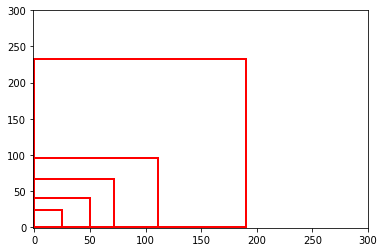

In [27]:
km = KMeans(k=5,dataset=dp.y_data_scaled)
anchors = km.fit(max_iterations=1000)
km.visualize_data(anchors)

DONE! Iteration = 10 
Accuracy =  0.736332601969166


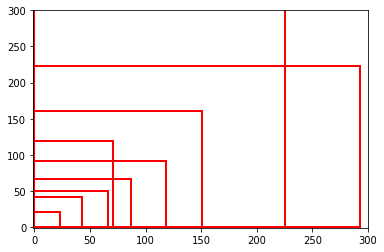

In [28]:
km = KMeans(k=9,dataset=dp.y_data_scaled)
anchors = km.fit(max_iterations=1000)
km.visualize_data(anchors)

DONE! Iteration = 33 
Accuracy =  0.7632764674249283
DONE! Iteration = 11 
Accuracy =  0.7446023326036153
DONE! Iteration = 34 
Accuracy =  0.7622018941191273
DONE! Iteration = 25 
Accuracy =  0.7522817408812754
DONE! Iteration = 21 
Accuracy =  0.716492657988468
DONE! Iteration = 12 
Accuracy =  0.7370803378774254
DONE! Iteration = 35 
Accuracy =  0.7172878235359205
DONE! Iteration = 54 
Accuracy =  0.7586670434186141
DONE! Iteration = 39 
Accuracy =  0.7482126780858436
DONE! Iteration = 9 
Accuracy =  0.7306904719343175
Mean Average IOU =  0.7430793447869536


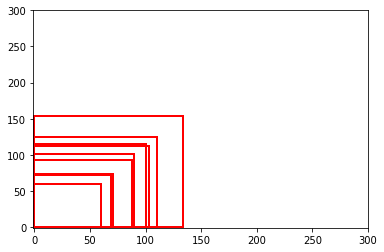

In [39]:
km = KMeans(k=9,dataset=dp.y_data_scaled)
anchors, ma_iou = km.fit_average(max_iterations=10)
print("Mean Average IOU = ", ma_iou)
km.visualize_data(anchors)